In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os.path
import biophysnn
import score_variants
import motifscanner
from pathlib import Path
from importlib import reload

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPK")

to_score = [ pd.read_csv(results_dir / ("beta_struct_rep%i.tsv.gz" % i), sep = "\t", index_col = False) for i 
       in range(2) ]

In [6]:
merged = to_score[0].merge(to_score[1], 
                           how = "outer",
                           on = ["contig", "position_hg19", "position", "variantID", "refAllele", "altAllele"], 
                           suffixes = ["_1","_2"])
merged

,contig,position_hg19,variantID,refAllele,altAllele,position,refCount_input_1,altCount_input_1,totalCount_input_1,pred_ratio_1,...,altCount_IP_2,totalCount_IP_2,shrunk_input_logratio_2,ase_loc_2,ase_sd_2,ase_q_2,shrunk_IP_logratio_2,asb_loc_2,asb_sd_2,asb_q_2
0,chr10,294953,rs1017361,A,G,249013,18.0,109.0,127.0,0.925054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr10,320954,rs10903832,A,G,275014,98.0,24.0,122.0,0.191076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr10,325134,rs12357593,C,T,279194,10.0,4.0,14.0,0.214894,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr10,327780,rs7908298,C,T,281840,11.0,7.0,18.0,0.410334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr10,347752,rs7918643,C,T,301812,12.0,9.0,21.0,0.302841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385766,chr9,140656514,rs7032719,T,C,137762062,NaN,NaN,NaN,NaN,...,10.0,32.0,-0.313579,-0.001680,0.194389,0.496553,-0.481719,-0.168140,0.218887,0.221197
385767,chr9,140709605,rs67116066,A,G,137815153,NaN,NaN,NaN,NaN,...,5.0,77.0,-2.339802,-0.206415,0.209092,0.161773,-2.468830,-0.129028,0.323983,0.345221
385768,chr9,140709647,rs72766964,A,G,137815195,NaN,NaN,NaN,NaN,...,5.0,99.0,-2.363194,-0.209030,0.249279,0.200865,-2.821070,-0.457876,0.455280,0.157279
385769,chr9,140866826,rs12352971,G,T,137972374,NaN,NaN,NaN,NaN,...,22.0,65.0,-1.159956,0.275054,0.194685,0.078855,-0.909258,0.250697,0.212544,0.119098


In [9]:
phys_net = motifscanner.PhysNet(torch.zeros(5,4,7), max_over_positions = False, max_over_motifs = False, seq_len = 600)
phys_net.load_state_dict(torch.load("checkpoints/posmax0_motifmax0_len600.pt"))

<All keys matched successfully>

In [10]:
genome = pickle.load(open("/gpfs/commons/home/daknowles/knowles_lab/index/hg38/hg38.pkl","rb")) # this is here in case there's hg38 data you want to analyse

In [16]:
np.mean([genome[merged.contig.iloc[i]][merged.position.iloc[i]-1] == merged.refAllele.iloc[i]for i in range(10000) ])

1.0

In [27]:
strand_lookup = pd.read_csv("/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/ipsc_imputation_het_hg38_stranded.bed", 
                            sep = "\t", 
                            index_col = False, 
                            skiprows = 1, 
                            names = ["chrom","position","end","variantID","refAllele","strand"])
del strand_lookup["end"]
strand_lookup

In [42]:
strand_lookup

,chrom,position,variantID,refAllele,strand
0,chr10,45349,chr10:45349_G/A,G,+
1,chr10,45386,chr10:45386_T/G,T,+
2,chr10,60826,chr10:60826_C/A,C,+
3,chr10,60845,chr10:60845_G/A,G,+
4,chr10,73872,chr10:73872_C/T,C,+
...,...,...,...,...,...
31591121,chr9,135999503,rs116510425,G,-
31591122,chr9,135999633,rs115864487,G,-
31591123,chr9,135999653,rs535269131,C,-
31591124,chr9,135999659,rs778067980,C,-


In [43]:
snpdata = merged.rename(columns = {"contig" : "chrom"}
             ).merge(strand_lookup, 
                     on = ["chrom", "position","variantID","refAllele"])
snpdata

,chrom,position_hg19,variantID,refAllele,altAllele,position,refCount_input_1,altCount_input_1,totalCount_input_1,pred_ratio_1,...,totalCount_IP_2,shrunk_input_logratio_2,ase_loc_2,ase_sd_2,ase_q_2,shrunk_IP_logratio_2,asb_loc_2,asb_sd_2,asb_q_2,strand
0,chr10,294953,rs1017361,A,G,249013,18.0,109.0,127.0,0.925054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,+
1,chr10,320954,rs10903832,A,G,275014,98.0,24.0,122.0,0.191076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-
2,chr10,325134,rs12357593,C,T,279194,10.0,4.0,14.0,0.214894,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-
3,chr10,327780,rs7908298,C,T,281840,11.0,7.0,18.0,0.410334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-
4,chr10,347752,rs7918643,C,T,301812,12.0,9.0,21.0,0.302841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385766,chr9,140656514,rs7032719,T,C,137762062,NaN,NaN,NaN,NaN,...,32.0,-0.313579,-0.001680,0.194389,0.496553,-0.481719,-0.168140,0.218887,0.221197,+
385767,chr9,140709605,rs67116066,A,G,137815153,NaN,NaN,NaN,NaN,...,77.0,-2.339802,-0.206415,0.209092,0.161773,-2.468830,-0.129028,0.323983,0.345221,+
385768,chr9,140709647,rs72766964,A,G,137815195,NaN,NaN,NaN,NaN,...,99.0,-2.363194,-0.209030,0.249279,0.200865,-2.821070,-0.457876,0.455280,0.157279,+
385769,chr9,140866826,rs12352971,G,T,137972374,NaN,NaN,NaN,NaN,...,65.0,-1.159956,0.275054,0.194685,0.078855,-0.909258,0.250697,0.212544,0.119098,+


In [128]:
alt_probs, ref_probs = score_variants.score_variants(phys_net, snpdata, genome)

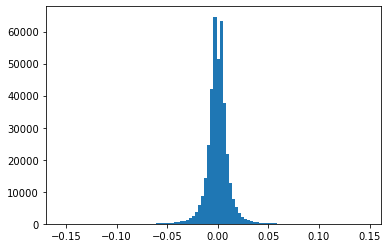

In [149]:
plt.hist( alt_probs - ref_probs, 100 )
plt.show()

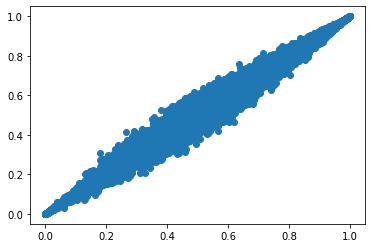

In [150]:
plt.scatter(ref_probs, alt_probs)

In [151]:
snpdata["vep"] = alt_probs - ref_probs

In [153]:
keep = ~snpdata.asb_loc_1.isna() & ~snpdata.asb_loc_2.isna()
shared = snpdata[keep]

Text(0.5, 1.0, 'R=0.024, p=6e-29')

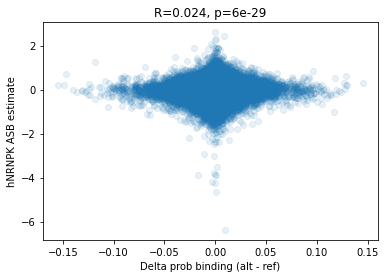

In [176]:
plt.scatter(shared.vep, shared.asb_loc_1 + shared.asb_loc_2, alpha=0.1)
(R,p) = scipy.stats.pearsonr( shared.vep, shared.asb_loc_1 + shared.asb_loc_2 )
plt.xlabel("Delta prob binding (alt - ref)")
plt.ylabel("hNRNPK ASB estimate")
plt.title("R=%.3f, p=%.1g" % (R,p))

In [170]:
scipy.stats.spearmanr( shared.vep, shared.asb_loc_1 + shared.asb_loc_2 )

SpearmanrResult(correlation=0.024725273444052957, pvalue=5.235697263302409e-30)

In [161]:
rep1_asb = ( (snpdata.altCount_IP_1+0.5) / (snpdata.altCount_input_1+0.5)) / ((snpdata.refCount_IP_1+0.5) / (snpdata.refCount_input_1+0.5))
rep2_asb = ( (snpdata.altCount_IP_2+0.5) / (snpdata.altCount_input_2+0.5)) / ((snpdata.refCount_IP_2+0.5) / (snpdata.refCount_input_2+0.5))
asb = .5 * (rep1_asb + rep2_asb)

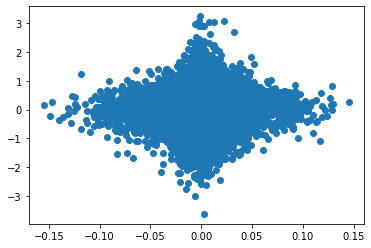

In [162]:
log_asb = np.log(asb) 
plt.scatter( alt_probs - ref_probs, log_asb )

In [163]:
keep = ~log_asb.isna() & ~np.isinf(log_asb)
scipy.stats.pearsonr( vep[keep], log_asb[keep] )

(0.024009398525659198, 2.172499484464552e-28)

In [142]:
np.isinf(log_asb[keep]).any()

True

## Break down by gene region

In [178]:
snpinfo = pd.read_csv("/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/220823_all_testable_snp_info_table.txt", 
                            sep = "\t", 
                            index_col = False)
snpinfo

,snp_chr,snp_start,snp_end,snp_id,distance_to_peak,peak_chr,peak_start,peak_end,peak_id,peak_score,...,pred_ratio,shrunk_input_logratio,ase_loc,ase_sd,ase_q,shrunk_IP_logratio,asb_loc,asb_sd,asb_q,gene_feature
0,chr18,49054943,49054944,rs1000055,168,chr18,49054773,49054774,all_hnrnpk_rep1_neg_peak_31164,241,...,0.453158,-0.211443,-0.023522,0.157609,0.440682,-0.301231,-0.089789,0.208681,0.333501,Intron
1,chr4,113625533,113625534,rs10000775,5535,chr4,113619996,113619997,all_hnrnpk_rep1_neg_peak_52145,42,...,0.466136,-0.250126,-0.114462,0.181879,0.264566,-0.194114,0.056013,0.200520,0.389993,Intron
2,chr4,38691214,38691215,rs1000096,10,chr4,38691226,38691227,all_hnrnpk_rep1_pos_peak_54546,25,...,0.379920,-0.226619,0.263270,0.164275,0.054509,-0.363252,-0.136633,0.184821,0.229870,Intron
3,chr4,110056974,110056975,rs10001138,82,chr4,110057058,110057059,all_hnrnpk_rep1_neg_peak_52093,68,...,0.232882,-1.147026,0.045082,0.211588,0.415639,-1.092259,0.054767,0.226932,0.404647,Intron
4,chr4,4732192,4732193,rs10001497,806,chr4,4733000,4733001,all_hnrnpk_rep1_pos_peak_53927,31,...,0.097733,-2.055520,0.167154,0.273043,0.270206,-1.917222,0.138298,0.279190,0.310175,Intron
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61580,chr4,16999983,16999984,rs9998880,769,chr4,16999212,16999213,all_hnrnpk_rep1_pos_peak_54282,274,...,0.635265,1.168572,0.613702,0.193222,0.000746,1.419558,0.250985,0.192575,0.096234,Intron
61581,chr9,7133798,7133799,rs999931,47,chr9,7133749,7133750,all_hnrnpk_rep1_pos_peak_71505,98,...,0.165388,-1.400440,0.218233,0.205501,0.144127,-1.304886,0.095553,0.227351,0.337137,Intron
61582,chr7,33824457,33824458,rs999938,191,chr7,33824650,33824651,all_hnrnpk_rep1_pos_peak_65265,53,...,0.314227,-0.817336,-0.036904,0.181115,0.419271,-0.765201,0.052135,0.176713,0.383988,Intron
61583,chr18,10710532,10710533,rs999954,21,chr18,10710509,10710510,all_hnrnpk_rep1_neg_peak_30224,17,...,0.294529,-0.909114,-0.035627,0.233097,0.439261,-0.867431,0.041683,0.206846,0.420147,Intron


In [186]:
wgenefeature = snpdata.merge(snpinfo.loc[:,["snp_chr", "snp_start", "snp_end", "snp_id", "distance_to_peak", "peak_chr", "peak_start",	"peak_score", "gene_feature"]]
              .rename(columns = {"snp_chr":"chrom","snp_start":"position", "snp_id":"variantID"}), 
              on = ["chrom","position", "variantID"])

In [188]:
keep = ~wgenefeature.asb_loc_1.isna() & ~wgenefeature.asb_loc_2.isna()
shared = wgenefeature[keep]

Text(0.5, 1.0, 'R=0.021, p=3e-05')

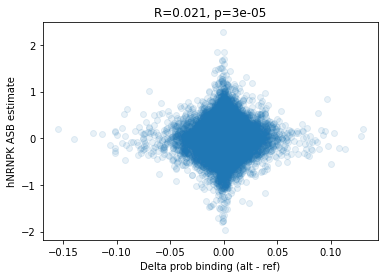

In [189]:
plt.scatter(shared.vep, shared.asb_loc_1 + shared.asb_loc_2, alpha=0.1)
(R,p) = scipy.stats.pearsonr( shared.vep, shared.asb_loc_1 + shared.asb_loc_2 )
plt.xlabel("Delta prob binding (alt - ref)")
plt.ylabel("hNRNPK ASB estimate")
plt.title("R=%.3f, p=%.1g" % (R,p))

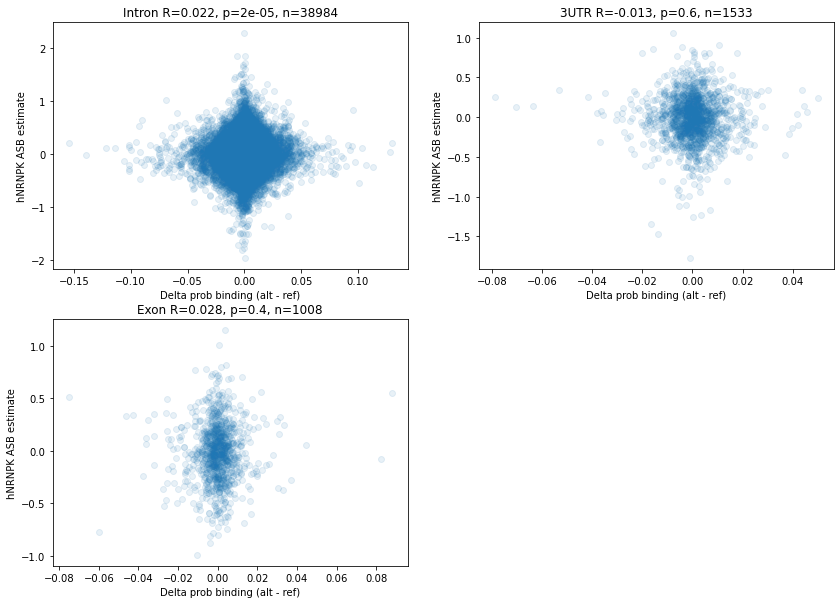

In [203]:
plt.figure(figsize=(14,10))
for i,gf in enumerate(shared.gene_feature.unique()):
    plt.subplot(2,2,i+1)
    sub = shared[shared.gene_feature == gf]
    plt.scatter(sub.vep, sub.asb_loc_1 + sub.asb_loc_2, alpha=0.1)
    (R,p) = scipy.stats.pearsonr( sub.vep, sub.asb_loc_1 + sub.asb_loc_2 )
    plt.xlabel("Delta prob binding (alt - ref)")
    plt.ylabel("hNRNPK ASB estimate")
    plt.title("%s R=%.3f, p=%.1g, n=%i" % (gf,R,p,len(sub)))

## Compare CNN scores

In [4]:
cnn_scores = pd.read_csv("CNN_variant_scores.tsv", 
                            sep = "\t", 
                            index_col = False)
cnn_scores

,chrom,position_hg19,position,variantID,refAllele,altAllele,strand,alt_pr_HNRNPA1,ref_pr_HNRNPA1,alt_pr_HNRNPK,ref_pr_HNRNPK,alt_pr_RBFOX2,ref_pr_RBFOX2
0,chr10,294953,249013,rs1017361,A,G,+,0.891329,0.894654,0.022875,0.023082,0.231722,0.206194
1,chr10,320954,275014,rs10903832,A,G,-,0.968047,0.974877,0.003672,0.002099,0.211513,0.298821
2,chr10,323034,277094,rs17158753,G,A,-,0.163890,0.244502,0.000856,0.000089,0.104606,0.113763
3,chr10,323283,277343,rs3740304,A,G,-,0.308609,0.240398,0.000462,0.000716,0.800671,0.781403
4,chr10,326894,280954,rs3125027,T,C,-,0.836334,0.831181,0.000140,0.000066,0.123271,0.190220
...,...,...,...,...,...,...,...,...,...,...,...,...,...
461122,chr9,140917779,138023327,rs7873074,G,T,+,0.000213,0.000899,0.000034,0.001157,0.477548,0.477763
461123,chr9,140939796,138045344,rs7865887,A,G,+,0.986960,0.987820,0.102118,0.099370,0.690293,0.736594
461124,chr9,141008876,138114424,rs2229948,C,T,+,0.066838,0.112323,0.025231,0.015572,0.568155,0.616872
461125,chr9,141017969,138123517,rs10867108,C,T,+,0.110724,0.149440,0.000600,0.001885,0.538110,0.517679


In [45]:
results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPK/")
#to_score = pd.read_csv(results_dir / "beta_struct_bblrt_rep0.tsv.gz", sep = "\t", index_col = False) 
to_score = pd.read_csv(results_dir / "beta_struct_bblrt_metaan.tsv.gz", sep = "\t", index_col = False) 
to_score

,contig,position_hg19,variantID,refAllele,altAllele,position,refCount_input_1,altCount_input_1,totalCount_input_1,pred_ratio_1,...,ase_loc_2,ase_sd_2,ase_q_2,shrunk_IP_logratio_2,asb_loc_2,asb_sd_2,asb_q_2,bb_lrt_p_2,bblrt_meta_p,beta_meta_p
0,chr10,406942,rs56400883,C,G,361002,18,10,28,0.386417,...,-0.145905,0.147314,0.160980,-0.652836,-0.210834,0.263691,0.211986,0.207873,0.356506,0.400062
1,chr10,407584,rs3922851,G,A,361644,8,11,19,0.319375,...,0.078545,0.215792,0.357934,-0.751466,0.004027,0.303972,0.494715,0.924281,0.245730,0.302867
2,chr10,407657,rs3922852,G,C,361717,22,12,34,0.576163,...,0.003407,0.165606,0.491792,0.161943,-0.044562,0.175860,0.399981,0.297971,0.048815,0.311624
3,chr10,408308,rs10904051,A,G,362368,6,15,21,0.631528,...,0.044044,0.199583,0.412670,0.334376,-0.357291,0.209271,0.043882,0.040303,0.164862,0.338445
4,chr10,423555,rs12245012,G,A,377615,26,5,31,0.153264,...,0.187994,0.253123,0.228832,-1.308416,-0.138695,0.298577,0.321138,0.227715,0.164352,0.171482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211785,chr9,141001866,rs10867107,T,C,138107414,24,5,29,0.254254,...,0.143822,0.179218,0.211132,-0.976925,-0.025987,0.211068,0.451006,0.928479,0.785233,0.462623
211786,chr9,141003534,rs9410071,G,A,138109082,17,15,32,0.613606,...,0.025264,0.174082,0.442306,0.481072,-0.094498,0.261533,0.358929,0.079138,0.131633,0.455300
211787,chr9,141003946,rs7357733,G,T,138109494,10,23,33,0.595935,...,-0.154924,0.205797,0.225786,0.138993,-0.197962,0.191776,0.150976,0.542011,0.223317,0.115118
211788,chr9,141005820,rs766375,C,T,138111368,28,11,39,0.254254,...,-0.121615,0.211887,0.282998,-1.152967,0.063408,0.271345,0.407617,0.732105,0.878115,0.371786


In [46]:
merged = to_score.rename(
    columns = {"contig" : "chrom"}
).merge(
    cnn_scores, 
    on = ["chrom", "position_hg19", "position", "variantID", "refAllele", "altAllele"]
)
merged

,chrom,position_hg19,variantID,refAllele,altAllele,position,refCount_input_1,altCount_input_1,totalCount_input_1,pred_ratio_1,...,bb_lrt_p_2,bblrt_meta_p,beta_meta_p,strand,alt_pr_HNRNPA1,ref_pr_HNRNPA1,alt_pr_HNRNPK,ref_pr_HNRNPK,alt_pr_RBFOX2,ref_pr_RBFOX2
0,chr10,406942,rs56400883,C,G,361002,18,10,28,0.386417,...,0.207873,0.356506,0.400062,-,0.360151,0.331943,0.059680,0.042421,0.289813,0.331424
1,chr10,407584,rs3922851,G,A,361644,8,11,19,0.319375,...,0.924281,0.245730,0.302867,-,0.238959,0.258169,0.322787,0.366402,0.331539,0.320288
2,chr10,407657,rs3922852,G,C,361717,22,12,34,0.576163,...,0.297971,0.048815,0.311624,-,0.083573,0.088912,0.565492,0.773591,0.432676,0.425319
3,chr10,408308,rs10904051,A,G,362368,6,15,21,0.631528,...,0.040303,0.164862,0.338445,-,0.033886,0.040056,0.446553,0.239068,0.343232,0.328338
4,chr10,423555,rs12245012,G,A,377615,26,5,31,0.153264,...,0.227715,0.164352,0.171482,-,0.512362,0.597805,0.630584,0.624163,0.300315,0.335128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211785,chr9,141001866,rs10867107,T,C,138107414,24,5,29,0.254254,...,0.928479,0.785233,0.462623,+,0.004053,0.002957,0.912026,0.831127,0.325170,0.297842
211786,chr9,141003534,rs9410071,G,A,138109082,17,15,32,0.613606,...,0.079138,0.131633,0.455300,+,0.046324,0.058408,0.002516,0.002379,0.011426,0.006823
211787,chr9,141003946,rs7357733,G,T,138109494,10,23,33,0.595935,...,0.542011,0.223317,0.115118,+,0.290245,0.314594,0.009712,0.003160,0.278763,0.270850
211788,chr9,141005820,rs766375,C,T,138111368,28,11,39,0.254254,...,0.732105,0.878115,0.371786,+,0.421403,0.508073,0.337659,0.185201,0.806894,0.795226


Text(0.5, 1.0, 'R=0.079, p=0.05 n=637')

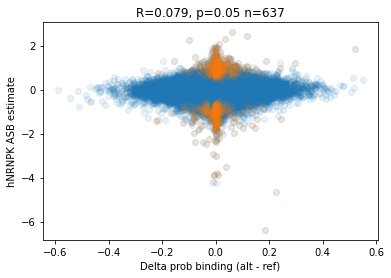

In [61]:
import scipy.stats
from scipy.special import logit
import statsmodels.stats.multitest
x = merged.alt_pr_HNRNPK - merged.ref_pr_HNRNPK
y = merged.asb_loc_1 + merged.asb_loc_2
_,q = statsmodels.stats.multitest.fdrcorrection(merged.beta_meta_p)
sig = q < 0.4
plt.scatter(x, y, alpha=0.1)
plt.scatter(x[sig], y[sig], alpha=0.1)
plt.xlabel("Delta prob binding (alt - ref)")
plt.ylabel("hNRNPK ASB estimate")
plt.title( ("R=%.3f, p=%.1g" % scipy.stats.pearsonr( x[sig], y[sig] )) + 
          " n=%i" % np.sum(sig))

Text(0.5, 1.0, 'R=0.073, p=1e-05')

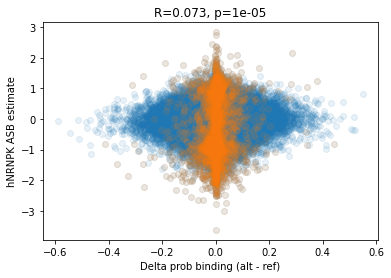

In [65]:
simple_asb = [ np.log(( (merged["altCount_IP_%i" % rep]+0.5) / (merged["altCount_input_%i" % rep]+0.5)) 
                      / ((merged["refCount_IP_%i" % rep]+0.5) / (merged["refCount_input_%i" % rep]+0.5))) for rep in [1,2]]
simple_asb = 0.5 * (simple_asb[0] + simple_asb[1])
x = merged.alt_pr_HNRNPK - merged.ref_pr_HNRNPK
y = simple_asb
sig = merged.bblrt_meta_p < 0.01
plt.scatter(x, y, alpha=0.1)
plt.scatter(x[sig], y[sig], alpha=0.1)
plt.xlabel("Delta prob binding (alt - ref)")
plt.ylabel("hNRNPK ASB estimate")
plt.title("R=%.3f, p=%.1g" % scipy.stats.pearsonr( x[sig], y[sig] ))